In [ ]:
"""
Dependencies:
    torch,
    transformers (https://pypi.org/project/transformers/)
    lm-eval (https://pypi.org/project/lm-eval/)
    jsonargparse (https://pypi.org/project/jsonargparse/)

Small model checkpoints for dev:
    AICrossSim/clm-60m (https://huggingface.co/AICrossSim/clm-60m)
    AICrossSim/clm-200m (https://huggingface.co/AICrossSim/clm-200m)
    TinyLlama/TinyLlama_v1.1 (https://huggingface.co/TinyLlama/TinyLlama_v1.1)

Reference evaluation results:
    AICrossSim/clm-60m, wikitext
    $ python demo.py eval --model_name AICrossSim/clm-60m
    | Tasks  |Version|Filter|n-shot|    Metric     |   | Value  |   |Stderr|
    |--------|------:|------|-----:|---------------|---|-------:|---|------|
    |wikitext|      2|none  |     0|bits_per_byte  |↓  |  1.6732|±  |   N/A|
    |        |       |none  |     0|byte_perplexity|↓  |  3.1893|±  |   N/A|
    |        |       |none  |     0|word_perplexity|↓  |493.7035|±  |   N/A|

    AICrossSim/clm-200m, wikitext
    $ python demo.py eval --model_name AICrossSim/clm-200m
    | Tasks  |Version|Filter|n-shot|    Metric     |   | Value |   |Stderr|
    |--------|------:|------|-----:|---------------|---|------:|---|------|
    |wikitext|      2|none  |     0|bits_per_byte  |↓  | 1.1067|±  |   N/A|
    |        |       |none  |     0|byte_perplexity|↓  | 2.1535|±  |   N/A|
    |        |       |none  |     0|word_perplexity|↓  |60.4573|±  |   N/A|
"""

from pathlib import Path
from typing import Optional, Union, Literal

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from lm_eval.evaluator import simple_evaluate
from lm_eval.models.huggingface import HFLM
from lm_eval.utils import make_table
from jsonargparse import CLI


def transform_model_to_MLA(model: torch.nn.Module, transform_config: dict[str, dict]):
    """transform model to MLA here."""
    print("Transforming model to MLA...")
    return model


def eval(
    model_name: str = "AICrossSim/clm-60m",
    transform_config: Optional[Path] = None,
    dtype: Literal["float32", "float16", "bfloat16"] = "bfloat16",
    tasks: Optional[list[str]] = ["wikitext"],
    num_fewshot: Optional[int] = None,
    batch_size: Optional[Union[int, str]] = 4,
    max_seq_len: Optional[int] = 2048,
    limit: Optional[Union[int, float]] = None,
):
    """Evaluate a pretrained model using lm-eval.

    batch_size="auto" to use the maximum batch size that fits in GPU memory
    """
    device = torch.device("cuda")
    # *: create the model and transform it on CPU if needed
    # *: attn_implementation="eager" is required otherwise transformers will use FlashAttn or torch SDPA
    model = AutoModelForCausalLM.from_pretrained(
        model_name, torch_dtype=getattr(torch, dtype), attn_implementation="eager"
    )
    model.eval()
    if transform_config is not None:
        # with open(transform_config, "r") as f:
        #     transform_config = yaml.safe_load(f)
        model = transform_model_to_MLA(model, transform_config)
    # # move the model to GPU
    model.to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # *: wrap the model with HFLM API
    model = HFLM(pretrained=model, tokenizer=tokenizer, batch_size=batch_size, max_length=max_seq_len)

    results = simple_evaluate(
        model=model,
        tasks=tasks,
        num_fewshot=num_fewshot,
        batch_size=batch_size,
        limit=limit,
    )

    if results is not None:
        results.pop("samples")
        print(make_table(results))
        if "groups" in results:
            print(make_table(results, "groups"))


if __name__ == "__main__":

    import os

    os.environ["TOKENIZERS_PARALLELISM"] = "false"

    cli_map = {
        "eval": eval,
    }
    CLI(cli_map)


usage: colab_kernel_launcher.py [-h] [--config CONFIG] [--print_config [=flags]] {eval} ...
error: argument subcommand: invalid choice: '/root/.local/share/jupyter/runtime/kernel-7fd9ce52-6ebe-4d45-be96-87c23cdfb7a4.json' (choose from 'eval')
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jsonargparse/_core.py", line 302, in parse_known_args
    namespace, args = self._parse_known_args(args, namespace, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/argparse.py", line 2143, in _parse_known_args
    stop_index = consume_positionals(start_index)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/argparse.py", line 2099, in consume_positionals
    take_action(action, args)
  File "/usr/lib/python3.11/argparse.py", line 1979, in take_action
    argument_values = self._get_values(action, argument_strings)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/argparse.py", line 2528, in _get_values
    self._check_value(action, value[0])
  File "/usr/lib/python3.11/argparse.py", line 2575, in _check_value
    raise ArgumentError(action, msg % args)
argparse.ArgumentErr

TypeError: object of type 'NoneType' has no len()

In [ ]:
!pip install lm_eval
!pip install jsonargparse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.3 MB/s eta 0:00:00
   

In [ ]:
!pip intall ipykernel

: 

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from lm_eval.evaluator import simple_evaluate
from lm_eval.models.huggingface import HFLM
from lm_eval.utils import make_table

device = torch.device("cuda")

def transform_model_to_MLA(model: torch.nn.Module, transform_config: dict):
    """Transform model to MLA (dummy implementation)."""
    print("Transforming model to MLA...")
    return model

def eval_model(model_name="AICrossSim/clm-60m", dtype="bfloat16", tasks=["wikitext"], batch_size=4, max_seq_len=2048):
    model = AutoModelForCausalLM.from_pretrained(
        model_name, torch_dtype=getattr(torch, dtype), attn_implementation="eager"
    ).to(device)

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    model = HFLM(pretrained=model, tokenizer=tokenizer, batch_size=batch_size, max_length=max_seq_len)

    results = simple_evaluate(model=model, tasks=tasks, batch_size=batch_size)

    if results:
        results.pop("samples", None)
        print(make_table(results))

# eval_model()


d:\MY_SOFTWARE\Anaconda\envs\llama\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
eval_model()


d:\MY_SOFTWARE\Anaconda\envs\llama\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--AICrossSim--clm-60m. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
`pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via a

KeyboardInterrupt: 

In [ ]:
eval_model(model_name="AICrossSim/clm-200m")


config.json:   0%|          | 0.00/822 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.05G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/140 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.94k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

Running loglikelihood requests: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


| Tasks  |Version|Filter|n-shot|    Metric     |   | Value |   |Stderr|
|--------|------:|------|-----:|---------------|---|------:|---|------|
|wikitext|      2|none  |     0|bits_per_byte  |↓  | 1.0994|±  |   N/A|
|        |       |none  |     0|byte_perplexity|↓  | 2.1427|±  |   N/A|
|        |       |none  |     0|word_perplexity|↓  |58.8575|±  |   N/A|



In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/ADLS/Origin-5epoch-2025_3_16/MODEL"


Mounted at /content/drive
checkpoint-13770  checkpoint-4590  generation_config.json  model.safetensors	    tokenizer.json
checkpoint-18360  checkpoint-9180  loss_curve.png	   special_tokens_map.json  vocab.json
checkpoint-22950  config.json	   merges.txt		   tokenizer_config.json    wikitext-2-v1


In [ ]:
# Set the correct model path
model_path = "/content/drive/My Drive/ADLS/Origin-5epoch-2025_3_16/MODEL"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Run evaluation
eval_model(model_name =model_path )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.76k [00:00<?, ?B/s]

wikitext-2-raw-v1-train.parquet:   0%|          | 0.00/6.18M [00:00<?, ?B/s]

wikitext-2-raw-v1-validation.parquet:   0%|          | 0.00/641k [00:00<?, ?B/s]

wikitext-2-raw-v1-test.parquet:   0%|          | 0.00/715k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/629 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/60 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/62 [00:00<?, ? examples/s]

Running loglikelihood requests: 100%|██████████| 1/1 [00:00<00:00, 27.04it/s]


| Tasks  |Version|Filter|n-shot|    Metric     |   |  Value  |   |Stderr|
|--------|------:|------|-----:|---------------|---|--------:|---|------|
|wikitext|      2|none  |     0|bits_per_byte  |↓  |   2.0381|±  |   N/A|
|        |       |none  |     0|byte_perplexity|↓  |   4.1071|±  |   N/A|
|        |       |none  |     0|word_perplexity|↓  |1909.2579|±  |   N/A|



In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ADLS


Mounted at /content/drive
/content/drive/MyDrive/ADLS


In [6]:
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer, LlamaConfig
from modeling_llama_HLA import LlamaRotaryEmbeddingmy, LlamaRotaryEmbedding, apply_rotary_pos_emb, apply_rotary_pos_emb_hla_fast_opt_v2

class RoPEBenchmark:
    def __init__(self, model_name="AICrossSim/clm-60m", tokenizer_name="HuggingFaceTB/cosmo2-tokenizer"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {self.device}")
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        if self.tokenizer.pad_token_id is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.config = LlamaConfig.from_pretrained(model_name)

        # Initialize both RoPE implementations
        self.rope_original = LlamaRotaryEmbedding(self.config).to(self.device)
        self.rope_new = LlamaRotaryEmbeddingmy(self.config).to(self.device)

        # Create B matrices for head-level adaptation
        head_dim = self.config.hidden_size // self.config.num_attention_heads
        num_heads = self.config.num_attention_heads
        total_dim = num_heads * head_dim

        # Initialize random B matrices for testing
        self.B_q = torch.randn(total_dim, total_dim).to(self.device)
        self.B_k = torch.randn(total_dim, total_dim).to(self.device)

    def generate_inputs(self, batch_size, seq_len):
        """Generate random inputs for benchmarking"""
        # Create position IDs
        position_ids = torch.arange(seq_len, dtype=torch.long).to(self.device)
        position_ids = position_ids.unsqueeze(0).expand(batch_size, -1)

        # Create query and key tensors
        head_dim = self.config.hidden_size // self.config.num_attention_heads
        num_heads = self.config.num_attention_heads

        q = torch.randn(batch_size, num_heads, seq_len, head_dim).to(self.device)
        k = torch.randn(batch_size, num_heads, seq_len, head_dim).to(self.device)

        return q, k, position_ids

    def benchmark_single_run(self, batch_size, seq_len, n_iterations=10, warmup=3):
        """Run benchmark for a specific batch size and sequence length"""
        q, k, position_ids = self.generate_inputs(batch_size, seq_len)

        # Warm-up runs
        for _ in range(warmup):
            # Original implementation
            cos_orig, sin_orig = self.rope_original(q, position_ids)
            q_embed_orig, k_embed_orig = apply_rotary_pos_emb(q, k, cos_orig, sin_orig)

            # New implementation
            cos_size_matrix = self.rope_new(q, position_ids)
            q_embed_new, k_embed_new = apply_rotary_pos_emb_hla_fast_opt_v2(q, k, cos_size_matrix, self.B_q, self.B_k)

        # Benchmark original implementation
        torch.cuda.synchronize() if self.device == "cuda" else None
        start_time = time.time()
        for _ in range(n_iterations):
            cos_orig, sin_orig = self.rope_original(q, position_ids)
            q_embed_orig, k_embed_orig = apply_rotary_pos_emb(q, k, cos_orig, sin_orig)
            torch.cuda.synchronize() if self.device == "cuda" else None
        orig_time = (time.time() - start_time) / n_iterations

        # Benchmark new implementation
        torch.cuda.synchronize() if self.device == "cuda" else None
        start_time = time.time()
        for _ in range(n_iterations):
            cos_size_matrix = self.rope_new(q, position_ids)
            q_embed_new, k_embed_new = apply_rotary_pos_emb_hla_fast_opt_v2(q, k, cos_size_matrix, self.B_q, self.B_k)
            torch.cuda.synchronize() if self.device == "cuda" else None
        new_time = (time.time() - start_time) / n_iterations

        # Calculate memory usage
        torch.cuda.reset_peak_memory_stats() if self.device == "cuda" else None
        cos_orig, sin_orig = self.rope_original(q, position_ids)
        q_embed_orig, k_embed_orig = apply_rotary_pos_emb(q, k, cos_orig, sin_orig)
        orig_memory = torch.cuda.max_memory_allocated() / 1024**2 if self.device == "cuda" else 0

        torch.cuda.reset_peak_memory_stats() if self.device == "cuda" else None
        cos_size_matrix = self.rope_new(q, position_ids)
        q_embed_new, k_embed_new = apply_rotary_pos_emb_hla_fast_opt_v2(q, k, cos_size_matrix, self.B_q, self.B_k)
        new_memory = torch.cuda.max_memory_allocated() / 1024**2 if self.device == "cuda" else 0

        return {
            "batch_size": batch_size,
            "seq_len": seq_len,
            "orig_time": orig_time * 1000,  # Convert to ms
            "new_time": new_time * 1000,    # Convert to ms
            "orig_memory": orig_memory,
            "new_memory": new_memory,
            "speedup": orig_time / new_time if new_time > 0 else float('inf'),
            "memory_ratio": new_memory / orig_memory if orig_memory > 0 else float('inf')
        }

    def run_benchmark(self, batch_sizes=[1, 4, 8], seq_lengths=[128, 512, 1024, 2048], n_iterations=10):
        """Run benchmark across different batch sizes and sequence lengths"""
        results = []

        for batch_size in batch_sizes:
            for seq_len in seq_lengths:
                print(f"Benchmarking batch_size={batch_size}, seq_len={seq_len}")
                result = self.benchmark_single_run(batch_size, seq_len, n_iterations)
                results.append(result)
                print(f"  Original: {result['orig_time']:.2f}ms, {result['orig_memory']:.2f}MB")
                print(f"  New: {result['new_time']:.2f}ms, {result['new_memory']:.2f}MB")
                print(f"  Speedup: {result['speedup']:.2f}x, Memory ratio: {result['memory_ratio']:.2f}x")

        return results

    def verify_outputs(self, batch_size=1, seq_len=128):
        """Verify that both implementations produce similar outputs"""
        q, k, position_ids = self.generate_inputs(batch_size, seq_len)

        # Original implementation
        cos_orig, sin_orig = self.rope_original(q, position_ids)
        q_embed_orig, k_embed_orig = apply_rotary_pos_emb(q, k, cos_orig, sin_orig)

        # New implementation
        cos_size_matrix = self.rope_new(q, position_ids)
        q_embed_new, k_embed_new = apply_rotary_pos_emb_hla_fast_opt_v2(q, k, cos_size_matrix, self.B_q, self.B_k)

        # Reshape new outputs to match original shape
        q_embed_new_reshaped = q_embed_new.view(batch_size, seq_len, self.config.num_attention_heads, -1).permute(0, 2, 1, 3)
        k_embed_new_reshaped = k_embed_new.view(batch_size, seq_len, self.config.num_attention_heads, -1).permute(0, 2, 1, 3)

        # Calculate differences
        q_diff = torch.abs(q_embed_orig - q_embed_new_reshaped).mean().item()
        k_diff = torch.abs(k_embed_orig - k_embed_new_reshaped).mean().item()

        return {
            "q_diff": q_diff,
            "k_diff": k_diff,
            "output_similar": q_diff < 1e-3 and k_diff < 1e-3
        }

    def plot_results(self, results):
        """Plot benchmark results"""
        batch_sizes = sorted(list(set([r["batch_size"] for r in results])))
        seq_lengths = sorted(list(set([r["seq_len"] for r in results])))

        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Time comparison
        ax = axes[0]
        width = 0.35
        x = np.arange(len(seq_lengths))

        for i, batch_size in enumerate(batch_sizes):
            batch_results = [r for r in results if r["batch_size"] == batch_size]
            batch_results.sort(key=lambda r: r["seq_len"])

            orig_times = [r["orig_time"] for r in batch_results]
            new_times = [r["new_time"] for r in batch_results]

            offset = width * (i - len(batch_sizes)/2 + 0.5)
            ax.bar(x + offset - width/4, orig_times, width/2, label=f"Original (bs={batch_size})")
            ax.bar(x + offset + width/4, new_times, width/2, label=f"New (bs={batch_size})")

        ax.set_ylabel('Time (ms)')
        ax.set_xlabel('Sequence Length')
        ax.set_title('Time Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(seq_lengths)
        ax.legend()

        # Memory comparison
        ax = axes[1]
        for i, batch_size in enumerate(batch_sizes):
            batch_results = [r for r in results if r["batch_size"] == batch_size]
            batch_results.sort(key=lambda r: r["seq_len"])

            orig_memory = [r["orig_memory"] for r in batch_results]
            new_memory = [r["new_memory"] for r in batch_results]

            offset = width * (i - len(batch_sizes)/2 + 0.5)
            ax.bar(x + offset - width/4, orig_memory, width/2, label=f"Original (bs={batch_size})")
            ax.bar(x + offset + width/4, new_memory, width/2, label=f"New (bs={batch_size})")

        ax.set_ylabel('Memory (MB)')
        ax.set_xlabel('Sequence Length')
        ax.set_title('Memory Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(seq_lengths)
        ax.legend()

        plt.tight_layout()
        plt.savefig('rope_benchmark_results.png')
        plt.show()

def main():
    # Initialize benchmark
    benchmark = RoPEBenchmark()

    # Verify output similarity
    # print("Verifying output similarity...")
    # similarity = benchmark.verify_outputs()
    # print(f"Output differences - Q: {similarity['q_diff']:.6f}, K: {similarity['k_diff']:.6f}")
    # print(f"Outputs similar: {similarity['output_similar']}")

    # Run benchmarks
    print("\nRunning benchmarks...")
    results = benchmark.run_benchmark(
        batch_sizes=[1, 4, 8],
        seq_lengths=[128, 512, 1024, 2048],
        n_iterations=5
    )

    # Plot results
    benchmark.plot_results(results)

    # Print summary
    print("\nSummary:")
    for batch_size in [1]:
        for seq_len in [128, 512, 1024, 2048]:
            result = next((r for r in results if r["batch_size"] == batch_size and r["seq_len"] == seq_len), None)
            if result:
                print(f"Batch={batch_size}, Seq={seq_len}: Speedup={result['speedup']:.2f}x, Memory={result['memory_ratio']:.2f}x")

if __name__ == "__main__":
    main()

Using device: cuda

Running benchmarks...
Benchmarking batch_size=1, seq_len=128


RuntimeError: The size of tensor a (64) must match the size of tensor b (2) at non-singleton dimension 4

/usr/local/lib/python3.11/dist-packages/torch/__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.91k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/489 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/821 [00:00<?, ?B/s]


=== GPU Information ===
CUDA Device: NVIDIA A100-SXM4-40GB
CUDA Version: 12.4
CUDA Capability: (8, 0)
Total GPU Memory: 39.56 GB

=== Running 20 Benchmark Sessions ===

=== Benchmark Session 1/20 ===

Benchmarking with batch_size=1, seq_len=512
  Original RoPE GPU memory: 8.63 MB
  HLA RoPE GPU memory: 8.63 MB
Speedup (HLA vs Original): 0.03x
  GPU utilization: 35%

Benchmarking with batch_size=1, seq_len=1024
  Original RoPE GPU memory: 9.13 MB
  HLA RoPE GPU memory: 9.13 MB
Speedup (HLA vs Original): 0.02x
  GPU utilization: 35%

Benchmarking with batch_size=1, seq_len=2048
  Original RoPE GPU memory: 10.14 MB
  HLA RoPE GPU memory: 10.14 MB
Speedup (HLA vs Original): 0.01x
  GPU utilization: 37%
Cooling GPU between sessions...

=== Benchmark Session 2/20 ===

Benchmarking with batch_size=1, seq_len=512
  Original RoPE GPU memory: 8.63 MB
  HLA RoPE GPU memory: 8.63 MB
Speedup (HLA vs Original): 0.03x
  GPU utilization: 29%

Benchmarking with batch_size=1, seq_len=1024
  Original Ro

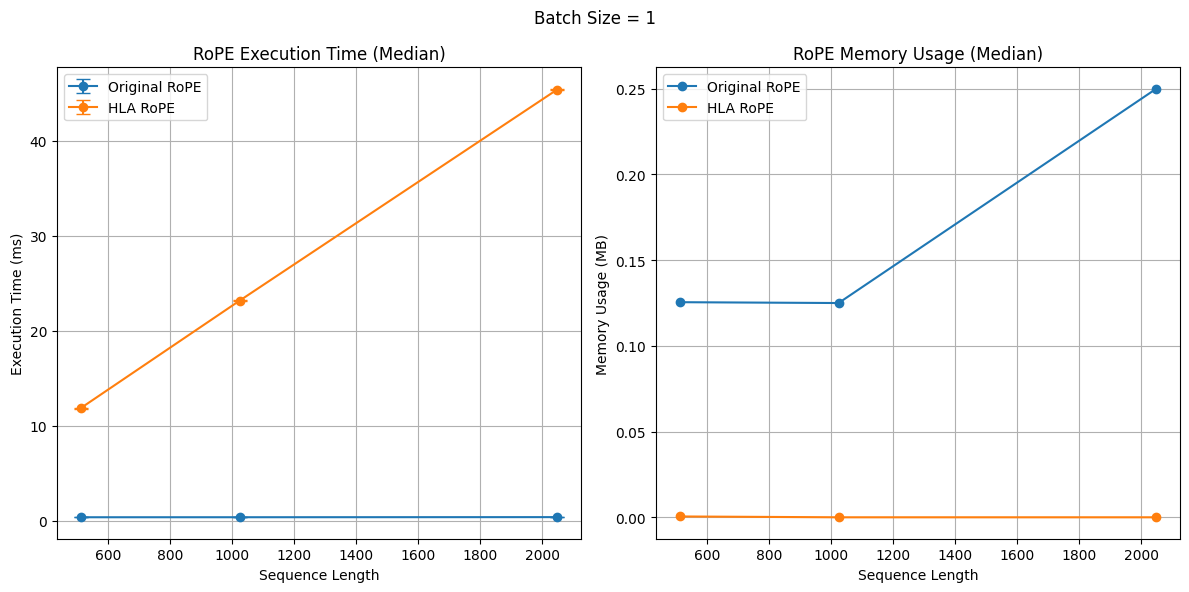


=== Running Detailed Profiling (batch_size=1, seq_len=2048) ===
Initial GPU memory usage: 16.14 MB
Max GPU memory allocated: 16.14 MB

Profiling iteration 1/5
Original RoPE Profile Events:
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls   Total FLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
    

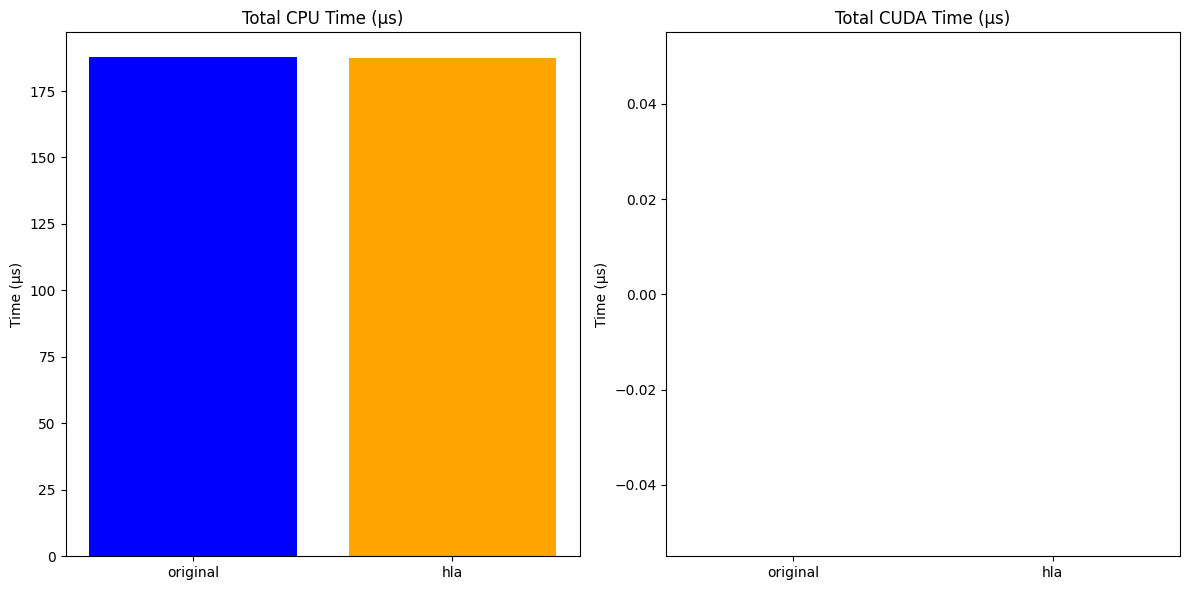


Benchmarking and profiling completed. Check the generated PNG files for graphs.


In [2]:
import torch
import time
import gc
import numpy as np
import psutil
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.profiler import profile, record_function, ProfilerActivity

from modeling_llama_HLA import LlamaRotaryEmbeddingmy, LlamaRotaryEmbedding
from transformers import AutoTokenizer, LlamaConfig

class RoPEBenchmark:
    def __init__(self, model_name="AICrossSim/clm-60m", tokenizer_name="HuggingFaceTB/cosmo2-tokenizer"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {self.device}")
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        if self.tokenizer.pad_token_id is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.config = LlamaConfig.from_pretrained(model_name)
        self.process = psutil.Process(os.getpid())

        # Enable CUDA benchmark mode for optimized performance on fixed-size inputs
        if self.device == "cuda":
            torch.backends.cudnn.benchmark = True

    def _clear_gpu_memory(self):
        if self.device == "cuda":
            torch.cuda.synchronize()
            torch.cuda.empty_cache()
        gc.collect()

    def _get_current_memory(self):
        if self.device == "cuda":
            return torch.cuda.memory_allocated() / (1024 ** 2)  # MB
        return self.process.memory_info().rss / (1024 ** 2)  # MB

    def _time_function(self, func, *args, trials=50, inner_loops=100):
        """
        Times inner_loops calls to func for each trial.
        Returns the median per-call time and its standard deviation.
        """
        times = []
        # More thorough warmup to ensure GPU is properly initialized
        for _ in range(10):  # Increased warmup iterations
            with torch.no_grad():
                for _ in range(inner_loops):
                    result = func(*args)
                    if self.device == "cuda":
                        torch.cuda.synchronize()  # Ensure operation completion

        if self.device == "cuda":
            for _ in range(trials):
                start_event = torch.cuda.Event(enable_timing=True)
                end_event = torch.cuda.Event(enable_timing=True)

                # Clear cache between trials for consistent measurement
                torch.cuda.empty_cache()
                torch.cuda.synchronize()

                start_event.record()
                with torch.no_grad():
                    for _ in range(inner_loops):
                        result = func(*args)
                        # Force result to be computed (prevent lazy evaluation)
                        _ = sum(t.sum() for t in result).item()
                end_event.record()
                torch.cuda.synchronize()
                total_time = start_event.elapsed_time(end_event) / 1000.0  # seconds
                times.append(total_time / inner_loops)
        else:
            for _ in range(trials):
                start_time = time.time()
                with torch.no_grad():
                    for _ in range(inner_loops):
                        _ = func(*args)
                total_time = time.time() - start_time
                times.append(total_time / inner_loops)

        return np.median(times), np.std(times)

    def benchmark_rope(self, batch_sizes=[1, 8], seq_lengths=[512, 1024, 2048, 4096],
                       head_dim=64, num_heads=6, trials=50, inner_loops=100):
        """
        Runs a benchmark for standalone RoPE implementations.
        Returns a dictionary with median timing and memory usage for both methods.
        Increased batch sizes and dimensions for better GPU utilization.
        """
        results = {"original": {"time": [], "memory": []},
                   "hla": {"time": [], "memory": []}}
        configs = [(batch, seq) for batch in batch_sizes for seq in seq_lengths]

        for batch_size, seq_len in configs:
            print(f"\nBenchmarking with batch_size={batch_size}, seq_len={seq_len}")
            # Prepare test inputs on device with larger dimensions for better GPU utilization
            hidden_states = torch.randn(batch_size, seq_len, num_heads * head_dim,
                                        dtype=torch.float16, device=self.device)
            position_ids = torch.arange(seq_len, dtype=torch.long, device=self.device).unsqueeze(0).expand(batch_size, -1)

            # Ensure tensors are actually on GPU
            if self.device == "cuda":
                assert hidden_states.is_cuda, "Hidden states not on CUDA"
                assert position_ids.is_cuda, "Position ids not on CUDA"

            # Benchmark Original RoPE
            self._clear_gpu_memory()
            start_mem = self._get_current_memory()
            original_rope = LlamaRotaryEmbedding(config=self.config).to(self.device)

            # Run warmup iteration and verify GPU usage
            with torch.no_grad():
                warmup_result = original_rope(hidden_states, position_ids)
                if self.device == "cuda":
                    assert warmup_result[0].is_cuda, "RoPE output not on CUDA"
                    torch.cuda.synchronize()
                    print(f"  Original RoPE GPU memory: {torch.cuda.memory_allocated() / (1024 ** 2):.2f} MB")

            torch.cuda.synchronize() if self.device == "cuda" else None
            orig_time, orig_error = self._time_function(original_rope, hidden_states, position_ids,
                                                        trials=trials, inner_loops=inner_loops)
            end_mem = self._get_current_memory()
            orig_mem_usage = end_mem - start_mem
            results["original"]["time"].append((batch_size, seq_len, orig_time, orig_error))
            results["original"]["memory"].append((batch_size, seq_len, orig_mem_usage))

            # Benchmark HLA RoPE
            self._clear_gpu_memory()
            start_mem = self._get_current_memory()
            hla_rope = LlamaRotaryEmbeddingmy(config=self.config).to(self.device)

            # Run warmup iteration and verify GPU usage
            with torch.no_grad():
                warmup_result = hla_rope(hidden_states, position_ids)
                if self.device == "cuda":
                    assert warmup_result.is_cuda, "HLA RoPE output not on CUDA"
                    torch.cuda.synchronize()
                    print(f"  HLA RoPE GPU memory: {torch.cuda.memory_allocated() / (1024 ** 2):.2f} MB")

            torch.cuda.synchronize() if self.device == "cuda" else None
            hla_time, hla_error = self._time_function(hla_rope, hidden_states, position_ids,
                                                      trials=trials, inner_loops=inner_loops)
            end_mem = self._get_current_memory()
            hla_mem_usage = end_mem - start_mem
            results["hla"]["time"].append((batch_size, seq_len, hla_time, hla_error))
            results["hla"]["memory"].append((batch_size, seq_len, hla_mem_usage))

            speedup = orig_time / hla_time if hla_time > 0 else float('inf')
            print(f"Speedup (HLA vs Original): {speedup:.2f}x")

            # Report GPU utilization if available
            if self.device == "cuda":
                print(f"  GPU utilization: {torch.cuda.utilization()}%")

        return results

    def run_multiple_sessions(self, sessions=5, **kwargs):
        """
        Runs the benchmark multiple times and aggregates results.
        Reduced number of sessions to avoid CUDA OOM errors.
        """
        all_results = []
        for i in range(sessions):
            print(f"\n=== Benchmark Session {i+1}/{sessions} ===")
            session_result = self.benchmark_rope(**kwargs)
            all_results.append(session_result)

            # Add explicit cooling period between sessions
            if self.device == "cuda" and i < sessions - 1:
                print("Cooling GPU between sessions...")
                self._clear_gpu_memory()
                time.sleep(2)  # Allow GPU to cool down

        # Aggregate results per configuration (keyed by (batch_size, seq_length))
        aggregated = {"original": {"time": {}, "memory": {}},
                      "hla": {"time": {}, "memory": {}}}
        for method in ["original", "hla"]:
            for res_type in ["time", "memory"]:
                for session in all_results:
                    for tup in session[method][res_type]:
                        key = (tup[0], tup[1])
                        aggregated[method][res_type].setdefault(key, []).append(tup[2])

        aggregated_results = {"original": {"time": [], "memory": []},
                              "hla": {"time": [], "memory": []}}
        for method in ["original", "hla"]:
            for key, values in aggregated[method]["time"].items():
                aggregated_results[method]["time"].append((key[0], key[1], np.median(values), np.std(values)))
            for key, values in aggregated[method]["memory"].items():
                aggregated_results[method]["memory"].append((key[0], key[1], np.median(values)))
        return aggregated_results

    def profile_rope_comparison_multi(self, batch_size=8, seq_len=2048, head_dim=64, num_heads=32, iterations=10):
        """
        Profiles both Original and HLA RoPE implementations over multiple iterations.
        Uses torch.profiler for detailed profiling and explicit CUDA events for HLA RoPE timing.
        """
        cpu_times_orig = []
        cuda_times_orig = []
        cpu_times_hla = []
        cuda_times_hla = []

        hidden_states = torch.randn(batch_size, seq_len, num_heads * head_dim,
                                    dtype=torch.float16, device=self.device)
        position_ids = torch.arange(seq_len, dtype=torch.long, device=self.device).unsqueeze(0).expand(batch_size, -1)

        if self.device == "cuda":
            print(f"Initial GPU memory usage: {torch.cuda.memory_allocated() / (1024 ** 2):.2f} MB")
            print(f"Max GPU memory allocated: {torch.cuda.max_memory_allocated() / (1024 ** 2):.2f} MB")

        manual_hla_cuda_time_ms = 0

        for i in range(iterations):
            print(f"\nProfiling iteration {i+1}/{iterations}")

            # --- Profile Original RoPE ---
            original_rope = LlamaRotaryEmbedding(config=self.config).to(self.device)

            # Warmup for original_rope
            for _ in range(5):
                with torch.no_grad():
                    warmup_result = original_rope(hidden_states, position_ids)
                    if self.device == "cuda":
                        _ = sum(t.sum() for t in warmup_result).item()
                        torch.cuda.synchronize()

            if self.device == "cuda":
                torch.cuda.synchronize()
                torch.cuda.reset_peak_memory_stats()

            # Profile original_rope with increased loop iterations to accumulate CUDA time
            with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA] if self.device == "cuda" else [ProfilerActivity.CPU],
                        record_shapes=True, profile_memory=True, with_stack=True, with_flops=True) as prof_orig:
                with record_function("original_rope"):
                    with torch.no_grad():
                        for _ in range(100):
                            result = original_rope(hidden_states, position_ids)
                            if self.device == "cuda":
                                _ = sum(t.sum() for t in result).item()
                        if self.device == "cuda":
                            torch.cuda.synchronize()

            if self.device == "cuda":
                torch.cuda.synchronize()

            events_orig = prof_orig.key_averages().table(sort_by="cuda_time_total", row_limit=10)
            print(f"Original RoPE Profile Events:\n{events_orig}")

            key_avg_orig = prof_orig.key_averages()
            total_cpu_orig = sum(item.cpu_time_total for item in key_avg_orig)
            total_cuda_orig = sum(getattr(item, "cuda_time_total", 0) for item in key_avg_orig) if self.device == "cuda" else 0
            cpu_times_orig.append(total_cpu_orig)
            cuda_times_orig.append(total_cuda_orig)

            if self.device == "cuda":
                print(f"  Original RoPE peak memory: {torch.cuda.max_memory_allocated() / (1024 ** 2):.2f} MB")
                print(f"  Original RoPE CUDA time (from profiler): {total_cuda_orig:.4f} μs")

            self._clear_gpu_memory()

            # --- Profile HLA RoPE ---
            hla_rope = LlamaRotaryEmbeddingmy(config=self.config).to(self.device)

            # Warmup for hla_rope
            for _ in range(5):
                with torch.no_grad():
                    warmup_result = hla_rope(hidden_states, position_ids)
                    if self.device == "cuda":
                        _ = warmup_result.sum().item()  # hla_rope returns a tensor
                        torch.cuda.synchronize()

            if self.device == "cuda":
                torch.cuda.synchronize()
                torch.cuda.reset_peak_memory_stats()

            # Use explicit CUDA events for manual timing of hla_rope
            if self.device == "cuda":
                start_event = torch.cuda.Event(enable_timing=True)
                end_event = torch.cuda.Event(enable_timing=True)
                torch.cuda.synchronize()
                start_event.record()

            with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA] if self.device == "cuda" else [ProfilerActivity.CPU],
                        record_shapes=True, profile_memory=True, with_stack=True, with_flops=True) as prof_hla:
                with record_function("hla_rope"):
                    with torch.no_grad():
                        for _ in range(100):
                            result = hla_rope(hidden_states, position_ids)
                            _ = result.sum().item()
                        if self.device == "cuda":
                            torch.cuda.synchronize()

            if self.device == "cuda":
                torch.cuda.synchronize()
                end_event.record()
                torch.cuda.synchronize()
                manual_hla_cuda_time_ms = start_event.elapsed_time(end_event)
                print(f"HLA RoPE measured CUDA elapsed time (manual timing): {manual_hla_cuda_time_ms:.4f} ms")
            else:
                manual_hla_cuda_time_ms = 0

            events_hla = prof_hla.key_averages().table(sort_by="cuda_time_total", row_limit=10)
            print(f"HLA RoPE Profile Events:\n{events_hla}")

            key_avg_hla = prof_hla.key_averages()
            total_cpu_hla = sum(item.cpu_time_total for item in key_avg_hla)
            total_cuda_hla = sum(getattr(item, "cuda_time_total", 0) for item in key_avg_hla) if self.device == "cuda" else 0
            cpu_times_hla.append(total_cpu_hla)
            cuda_times_hla.append(total_cuda_hla)

            if self.device == "cuda":
                print(f"  HLA RoPE peak memory: {torch.cuda.max_memory_allocated() / (1024 ** 2):.2f} MB")
                print(f"  HLA RoPE CUDA time (from profiler): {total_cuda_hla:.4f} μs")

            self._clear_gpu_memory()

        # Use filtered values for median calculation if available
        cuda_times_orig_filtered = [t for t in cuda_times_orig if t > 0]
        cuda_times_hla_filtered = [t for t in cuda_times_hla if t > 0]

        cuda_orig_median = np.median(cuda_times_orig_filtered) if cuda_times_orig_filtered else np.median(cuda_times_orig)
        cuda_hla_median = np.median(cuda_times_hla_filtered) if cuda_times_hla_filtered else np.median(cuda_times_hla)

        aggregated_metrics = {
            "original": {
                "total_cpu_time": np.median(cpu_times_orig),
                "total_cuda_time": cuda_orig_median if self.device == "cuda" else None
            },
            "hla": {
                "total_cpu_time": np.median(cpu_times_hla),
                "total_cuda_time": cuda_hla_median if self.device == "cuda" else None,
                "manual_cuda_time_ms": manual_hla_cuda_time_ms if self.device == "cuda" else None
            }
        }

        if self.device == "cuda":
            print("\nCUDA Operations Profile Summary:")
            print("Original RoPE CUDA Time (from profiler): {:.4f} μs".format(aggregated_metrics["original"]["total_cuda_time"]))
            print("HLA RoPE CUDA Time (from profiler): {:.4f} μs".format(aggregated_metrics["hla"]["total_cuda_time"]))
            print("HLA RoPE CUDA Time (manual timing): {:.4f} ms".format(aggregated_metrics["hla"]["manual_cuda_time_ms"]))

            if aggregated_metrics["original"]["total_cuda_time"] > 0 and aggregated_metrics["hla"]["total_cuda_time"] > 0:
                speedup = aggregated_metrics["original"]["total_cuda_time"] / aggregated_metrics["hla"]["total_cuda_time"]
                print("Speedup (CUDA): {:.2f}x".format(speedup))
            else:
                print("Speedup (CUDA): Unable to calculate (one or both times are zero)")

        return aggregated_metrics


    def plot_profiling_comparison(self, metrics):
        """
        Plots a bar chart comparing aggregated CPU and CUDA times in microseconds.
        """
        methods = ["original", "hla"]
        cpu_times = [metrics[m]["total_cpu_time"] for m in methods]
        # Convert to microseconds (original times are in nanoseconds)
        cpu_times_us = [t / 1000.0 for t in cpu_times]

        fig, axs = plt.subplots(1, 2 if self.device == "cuda" else 1, figsize=(12, 6))

        if self.device == "cuda":
            cuda_times = [metrics[m]["total_cuda_time"] for m in methods]
            # Convert to microseconds
            cuda_times_us = [t / 1000.0 for t in cuda_times]

            axs[0].bar(methods, cpu_times_us, color=['blue', 'orange'])
            axs[0].set_title("Total CPU Time (μs)")
            axs[0].set_ylabel("Time (μs)")

            axs[1].bar(methods, cuda_times_us, color=['blue', 'orange'])
            axs[1].set_title("Total CUDA Time (μs)")
            axs[1].set_ylabel("Time (μs)")
        else:
            axs.bar(methods, cpu_times_us, color=['blue', 'orange'])
            axs.set_title("Total CPU Time (μs)")
            axs.set_ylabel("Time (μs)")

        plt.tight_layout()
        plt.savefig("profiling_comparison_microseconds.png")
        plt.show()

    def plot_results(self, results):
        """
        Plots aggregated benchmark results (execution time and memory usage) versus sequence length.
        """
        # Group by batch size
        batch_sizes = sorted(set(x[0] for x in results["original"]["time"]))

        for batch_size in batch_sizes:
            seq_lengths = sorted(set(x[1] for x in results["original"]["time"] if x[0] == batch_size))
            orig_time, orig_std, hla_time, hla_std = [], [], [], []
            orig_mem, hla_mem = [], []

            for seq in seq_lengths:
                orig_entries = [t for t in results["original"]["time"] if t[0] == batch_size and t[1] == seq]
                hla_entries = [t for t in results["hla"]["time"] if t[0] == batch_size and t[1] == seq]
                orig_mem_entries = [m for m in results["original"]["memory"] if m[0] == batch_size and m[1] == seq]
                hla_mem_entries = [m for m in results["hla"]["memory"] if m[0] == batch_size and m[1] == seq]

                if orig_entries:
                    times = [entry[2] for entry in orig_entries]
                    stds = [entry[3] for entry in orig_entries]
                    orig_time.append(np.median(times)*1000)
                    orig_std.append(np.median(stds)*1000)
                else:
                    orig_time.append(0)
                    orig_std.append(0)
                if hla_entries:
                    times = [entry[2] for entry in hla_entries]
                    stds = [entry[3] for entry in hla_entries]
                    hla_time.append(np.median(times)*1000)
                    hla_std.append(np.median(stds)*1000)
                else:
                    hla_time.append(0)
                    hla_std.append(0)
                if orig_mem_entries:
                    mems = [entry[2] for entry in orig_mem_entries]
                    orig_mem.append(np.median(mems))
                else:
                    orig_mem.append(0)
                if hla_mem_entries:
                    mems = [entry[2] for entry in hla_mem_entries]
                    hla_mem.append(np.median(mems))
                else:
                    hla_mem.append(0)

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
            fig.suptitle(f"Batch Size = {batch_size}")

            ax1.errorbar(seq_lengths, orig_time, yerr=orig_std, label="Original RoPE", marker='o', capsize=5)
            ax1.errorbar(seq_lengths, hla_time, yerr=hla_std, label="HLA RoPE", marker='o', capsize=5)
            ax1.set_xlabel("Sequence Length")
            ax1.set_ylabel("Execution Time (ms)")
            ax1.set_title("RoPE Execution Time (Median)")
            ax1.legend()
            ax1.grid(True)

            ax2.plot(seq_lengths, orig_mem, label="Original RoPE", marker='o')
            ax2.plot(seq_lengths, hla_mem, label="HLA RoPE", marker='o')
            ax2.set_xlabel("Sequence Length")
            ax2.set_ylabel("Memory Usage (MB)")
            ax2.set_title("RoPE Memory Usage (Median)")
            ax2.legend()
            ax2.grid(True)

            plt.tight_layout()
            plt.savefig(f"aggregated_rope_benchmark_results_batch_{batch_size}.png")
            plt.show()

if __name__ == "__main__":
    # Set larger default tensor type for better GPU utilization
    torch.set_default_tensor_type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)

    # Set environment variables for better GPU performance
    os.environ["CUDA_LAUNCH_BLOCKING"] = "0"  # Enable asynchronous CUDA execution

    benchmark = RoPEBenchmark(model_name="AICrossSim/clm-60m", tokenizer_name="HuggingFaceTB/cosmo2-tokenizer")

    if torch.cuda.is_available():
        print("\n=== GPU Information ===")
        print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
        print(f"CUDA Version: {torch.version.cuda}")
        print(f"CUDA Capability: {torch.cuda.get_device_capability(0)}")
        print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.2f} GB")

    # Use fewer sessions but larger batch sizes and models
    sessions = 20
    print(f"\n=== Running {sessions} Benchmark Sessions ===")
    aggregated_results = benchmark.run_multiple_sessions(
        sessions=sessions,
        batch_sizes=[1],  # Increased batch sizes for better GPU utilization
        seq_lengths=[512, 1024, 2048],
        head_dim=64,  # Increased head dimension
        num_heads=6,
        trials=20,  # Reduced trials to avoid OOM
        inner_loops=50
    )

    print("\nAggregated Benchmark Results:")
    for method in ["original", "hla"]:
        for tup in aggregated_results[method]["time"]:
            print(f"{method} - Batch: {tup[0]}, Seq: {tup[1]}, Median Time: {tup[2]*1000:.2f} ms ± {tup[3]*1000:.2f} ms")
        for tup in aggregated_results[method]["memory"]:
            print(f"{method} - Batch: {tup[0]}, Seq: {tup[1]}, Memory Usage: {tup[2]:.2f} MB")

    benchmark.plot_results(aggregated_results)

    print("\n=== Running Detailed Profiling (batch_size=1, seq_len=2048) ===")
    profiling_metrics = benchmark.profile_rope_comparison_multi(batch_size=1, seq_len=2048, iterations=5)
    benchmark.plot_profiling_comparison(profiling_metrics)

    print("\nBenchmarking and profiling completed. Check the generated PNG files for graphs.")

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.91k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/489 [00:00<?, ?B/s]

Loading original Llama model from AICrossSim/clm-60m...


config.json:   0%|          | 0.00/821 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/140 [00:00<?, ?B/s]

Loading HLA Llama model from AICrossSim/clm-60m...


Some weights of LlamaForCausalLM were not initialized from the model checkpoint at AICrossSim/clm-60m and are newly initialized: ['model.layers.0.self_attn.k_d_proj.bias', 'model.layers.0.self_attn.k_d_proj.weight', 'model.layers.0.self_attn.k_u_proj.bias', 'model.layers.0.self_attn.k_u_proj.weight', 'model.layers.0.self_attn.q_d_proj.bias', 'model.layers.0.self_attn.q_d_proj.weight', 'model.layers.0.self_attn.q_u_proj.bias', 'model.layers.0.self_attn.q_u_proj.weight', 'model.layers.0.self_attn.v_d_proj.bias', 'model.layers.0.self_attn.v_d_proj.weight', 'model.layers.0.self_attn.v_u_proj.bias', 'model.layers.0.self_attn.v_u_proj.weight', 'model.layers.1.self_attn.k_d_proj.bias', 'model.layers.1.self_attn.k_d_proj.weight', 'model.layers.1.self_attn.k_u_proj.bias', 'model.layers.1.self_attn.k_u_proj.weight', 'model.layers.1.self_attn.q_d_proj.bias', 'model.layers.1.self_attn.q_d_proj.weight', 'model.layers.1.self_attn.q_u_proj.bias', 'model.layers.1.self_attn.q_u_proj.weight', 'model.lay


=== Running Inference Benchmark ===

Benchmarking inference with seq_length=128, gen_length=10
Input text: The future of AI is
Original Llama: Mean Time: 3632.05 ms (Median: 3632.05 ms), Std: 0.00 ms, Peak Memory: 336.65 MB
HLA Llama: Mean Time: 33968.03 ms (Median: 33968.03 ms), Std: 0.00 ms, Peak Memory: 367.64 MB
Speedup (HLA vs Original): 0.11x
Memory reduction: -9.21%
Output similarity score: 0.1143

Sample output comparison:
Original: The future of AI is to create a unique environment.
The global economy is a 1990s climate that is a ...
HLA: The future of AI is to bring the way to protect against the body mass of the front--------------stat...

Benchmarking inference with seq_length=256, gen_length=10
Input text: The future of AI is
Original Llama: Mean Time: 8678.26 ms (Median: 8678.26 ms), Std: 0.00 ms, Peak Memory: 338.03 MB
HLA Llama: Mean Time: 67079.44 ms (Median: 67079.44 ms), Std: 0.00 ms, Peak Memory: 367.65 MB
Speedup (HLA vs Original): 0.13x
Memory reduction: -8.76%
O

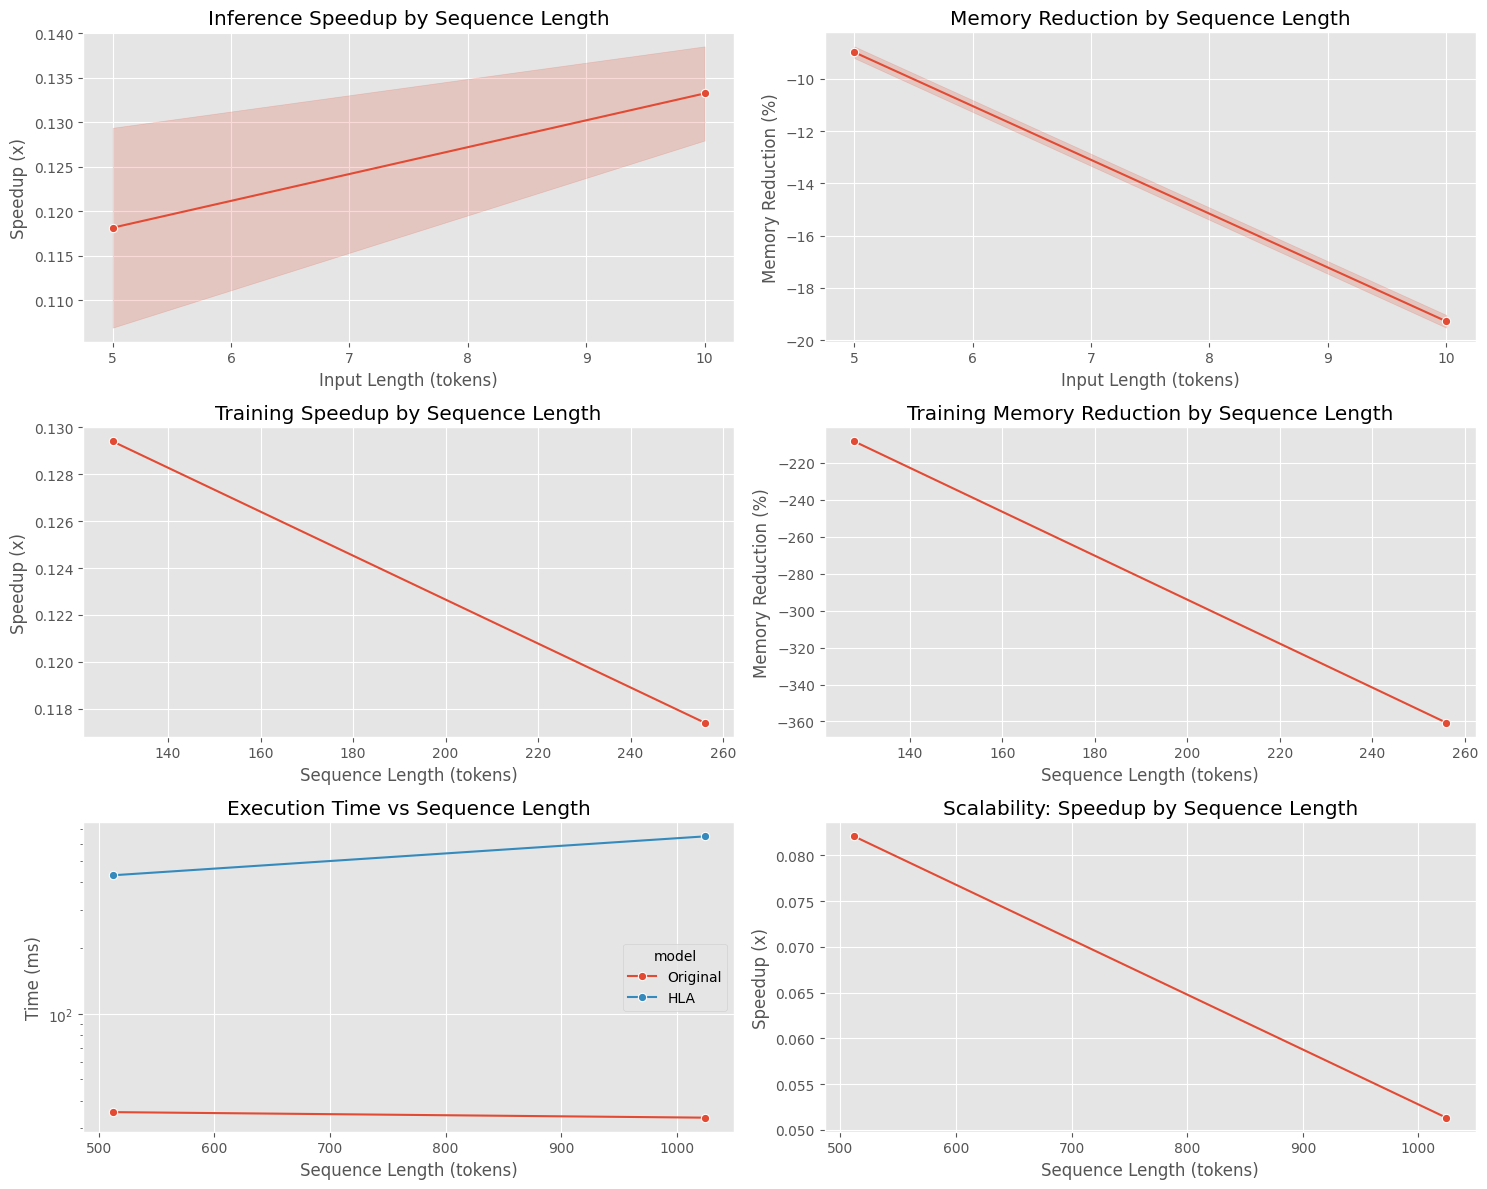


=== Benchmark Results Summary ===
                                 Metric    Value
              Inference Average Speedup    0.13x
              Inference Maximum Speedup    0.14x
     Inference Average Memory Reduction  -14.13%
               Training Average Speedup    0.12x
               Training Maximum Speedup    0.13x
      Training Average Memory Reduction -284.56%
Original Max Successful Sequence Length     1024
     HLA Max Successful Sequence Length     1024

Detailed results and plots saved to benchmark_results/


In [4]:
import torch
import time
import gc
import numpy as np
import psutil
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from torch.profiler import profile, record_function
from torch.profiler import profile, record_function, ProfilerActivity

from transformers import AutoTokenizer, LlamaConfig, LlamaForCausalLM
from modeling_llama_HLA import LlamaForCausalLM as LlamaForCausalLM_HLA

class LlamaBenchmark:
    def __init__(self, model_name="AICrossSim/clm-60m", tokenizer_name="HuggingFaceTB/cosmo2-tokenizer", enable_profiling=False):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {self.device}")
        self.model_name = model_name
        self.tokenizer_name = tokenizer_name
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        if self.tokenizer.pad_token_id is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.process = psutil.Process(os.getpid())
        self.enable_profiling = enable_profiling

        # Create output directory
        self.output_dir = "benchmark_results"
        os.makedirs(self.output_dir, exist_ok=True)

    def _clear_gpu_memory(self):
        if self.device == "cuda":
            torch.cuda.empty_cache()
        gc.collect()

    def _time_and_memory_function(self, func, *args, trials=10, **kwargs):
        times = []
        peak_memories = []
        result = None
        # Warmup runs
        for _ in range(3):
            with torch.no_grad():
                result = func(*args, **kwargs)

        for _ in range(trials):
            if self.device == "cuda":
                torch.cuda.synchronize()
                torch.cuda.reset_peak_memory_stats()
                start_event = torch.cuda.Event(enable_timing=True)
                end_event = torch.cuda.Event(enable_timing=True)
                start_event.record()
                with torch.no_grad():
                    result = func(*args, **kwargs)
                end_event.record()
                torch.cuda.synchronize()
                trial_time = start_event.elapsed_time(end_event) / 1000.0
                trial_peak = torch.cuda.max_memory_allocated() / (1024 ** 2)
            else:
                gc.collect()
                start_mem = self.process.memory_info().rss
                start_time = time.time()
                with torch.no_grad():
                    result = func(*args, **kwargs)
                trial_time = time.time() - start_time
                end_mem = self.process.memory_info().rss
                trial_peak = (end_mem - start_mem) / (1024 ** 2)
            times.append(trial_time)
            peak_memories.append(trial_peak)
        return np.mean(times), np.std(times), np.median(times), np.mean(peak_memories), result

    def load_models(self):
        print(f"Loading original Llama model from {self.model_name}...")
        self._clear_gpu_memory()
        self.original_model = LlamaForCausalLM.from_pretrained(
            self.model_name,
            ignore_mismatched_sizes=True,
            torch_dtype=torch.float16
        ).to(self.device)
        self.original_model.eval()

        print(f"Loading HLA Llama model from {self.model_name}...")
        self._clear_gpu_memory()
        self.hla_model = LlamaForCausalLM_HLA.from_pretrained(
            self.model_name,
            ignore_mismatched_sizes=True,
            torch_dtype=torch.float16
        ).to(self.device)
        self.hla_model.eval()

    def benchmark_inference(self, input_texts, seq_lengths=[128, 256, 512, 1024, 2048], gen_lengths=[20, 50, 100], trials=10):
        if not hasattr(self, 'original_model') or not hasattr(self, 'hla_model'):
            self.load_models()

        results = []
        for input_text in input_texts:
            for seq_length in seq_lengths:
                for gen_length in gen_lengths:
                    print(f"\nBenchmarking inference with seq_length={seq_length}, gen_length={gen_length}")
                    print(f"Input text: {input_text[:50]}{'...' if len(input_text) > 50 else ''}")

                    inputs = self.tokenizer(
                        input_text,
                        return_tensors="pt",
                        padding=True,
                        truncation=True,
                        max_length=seq_length,
                        return_attention_mask=True
                    ).to(self.device)

                    generation_kwargs = {
                        "max_length": seq_length + gen_length,
                        "do_sample": True,
                        "temperature": 0.7,
                        "top_k": 50,
                        "eos_token_id": self.tokenizer.eos_token_id,
                        "pad_token_id": self.tokenizer.pad_token_id
                    }

                    # Benchmark original model
                    self._clear_gpu_memory()
                    orig_time, orig_std, orig_median, orig_peak_mem, orig_output = self._time_and_memory_function(
                        self.original_model.generate,
                        inputs.input_ids,
                        attention_mask=inputs.attention_mask,
                        trials=trials,
                        **generation_kwargs
                    )

                    # Optional profiling (run once if enabled)
                    if self.enable_profiling:
                        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as orig_prof:
                            with record_function("original_model_generate"):
                                self.original_model.generate(
                                    inputs.input_ids,
                                    attention_mask=inputs.attention_mask,
                                    **generation_kwargs
                                )

                    orig_decoded = self.tokenizer.decode(orig_output[0], skip_special_tokens=True)
                    print(f"Original Llama: Mean Time: {orig_time*1000:.2f} ms (Median: {orig_median*1000:.2f} ms), Std: {orig_std*1000:.2f} ms, Peak Memory: {orig_peak_mem:.2f} MB")

                    # Benchmark HLA model
                    self._clear_gpu_memory()
                    hla_time, hla_std, hla_median, hla_peak_mem, hla_output = self._time_and_memory_function(
                        self.hla_model.generate,
                        inputs.input_ids,
                        attention_mask=inputs.attention_mask,
                        trials=trials,
                        **generation_kwargs
                    )

                    if self.enable_profiling:
                        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as hla_prof:
                            with record_function("hla_model_generate"):
                                self.hla_model.generate(
                                    inputs.input_ids,
                                    attention_mask=inputs.attention_mask,
                                    **generation_kwargs
                                )

                    hla_decoded = self.tokenizer.decode(hla_output[0], skip_special_tokens=True)
                    print(f"HLA Llama: Mean Time: {hla_time*1000:.2f} ms (Median: {hla_median*1000:.2f} ms), Std: {hla_std*1000:.2f} ms, Peak Memory: {hla_peak_mem:.2f} MB")

                    speedup = orig_time / hla_time if hla_time > 0 else float('inf')
                    memory_reduction = (orig_peak_mem - hla_peak_mem) / orig_peak_mem * 100 if orig_peak_mem > 0 else 0
                    print(f"Speedup (HLA vs Original): {speedup:.2f}x")
                    print(f"Memory reduction: {memory_reduction:.2f}%")

                    bleu_score = self.compute_similarity(orig_decoded, hla_decoded)
                    print(f"Output similarity score: {bleu_score:.4f}")

                    results.append({
                        "input_length": len(inputs.input_ids[0]),
                        "gen_length": gen_length,
                        "orig_mean_time_ms": orig_time * 1000,
                        "orig_median_time_ms": orig_median * 1000,
                        "hla_mean_time_ms": hla_time * 1000,
                        "hla_median_time_ms": hla_median * 1000,
                        "orig_peak_memory_mb": orig_peak_mem,
                        "hla_peak_memory_mb": hla_peak_mem,
                        "speedup": speedup,
                        "memory_reduction": memory_reduction,
                        "output_similarity": bleu_score
                    })

                    print("\nSample output comparison:")
                    print(f"Original: {orig_decoded[:100]}...")
                    print(f"HLA: {hla_decoded[:100]}...")

        df = pd.DataFrame(results)
        return df

    def benchmark_training(self, batch_sizes=[1, 2, 4], seq_lengths=[128, 256, 512, 1024], trials=10):
        if not hasattr(self, 'original_model') or not hasattr(self, 'hla_model'):
            self.load_models()

        self.original_model.train()
        self.hla_model.train()
        results = []

        for batch_size in batch_sizes:
            for seq_length in seq_lengths:
                print(f"\nBenchmarking training with batch_size={batch_size}, seq_length={seq_length}")
                input_ids = torch.randint(
                    0, self.tokenizer.vocab_size,
                    (batch_size, seq_length),
                    dtype=torch.long, device=self.device
                )
                attention_mask = torch.ones_like(input_ids)
                labels = input_ids.clone()

                self._clear_gpu_memory()
                def train_step_original():
                    self.original_model.zero_grad()

                    # Ensure model parameters require gradients
                    for param in self.original_model.parameters():
                        param.requires_grad = True

                    outputs = self.original_model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels,
                    )
                    loss = outputs.loss

                    # Check if we're in a no_grad context before calling backward
                    if torch.is_grad_enabled():
                        loss.backward()

                    return loss.item()
                orig_time, orig_std, orig_median, orig_peak_mem, orig_loss = self._time_and_memory_function(train_step_original, trials=trials)
                print(f"Original Llama: Mean Time: {orig_time*1000:.2f} ms (Median: {orig_median*1000:.2f} ms), Std: {orig_std*1000:.2f} ms, Peak Memory: {orig_peak_mem:.2f} MB, Loss: {orig_loss:.4f}")

                self._clear_gpu_memory()
                def train_step_hla():
                    self.hla_model.zero_grad()

                    # Ensure model parameters require gradients
                    for param in self.hla_model.parameters():
                        param.requires_grad = True

                    outputs = self.hla_model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels,
                    )
                    loss = outputs.loss

                    # Check if we're in a no_grad context before calling backward
                    if torch.is_grad_enabled():
                        loss.backward()

                    return loss.item()

                hla_time, hla_std, hla_median, hla_peak_mem, hla_loss = self._time_and_memory_function(train_step_hla, trials=trials)
                print(f"HLA Llama: Mean Time: {hla_time*1000:.2f} ms (Median: {hla_median*1000:.2f} ms), Std: {hla_std*1000:.2f} ms, Peak Memory: {hla_peak_mem:.2f} MB, Loss: {hla_loss:.4f}")

                speedup = orig_time / hla_time if hla_time > 0 else float('inf')
                memory_reduction = (orig_peak_mem - hla_peak_mem) / orig_peak_mem * 100 if orig_peak_mem > 0 else 0
                loss_diff = abs(orig_loss - hla_loss)
                print(f"Speedup (HLA vs Original): {speedup:.2f}x")
                print(f"Memory reduction: {memory_reduction:.2f}%")
                print(f"Loss difference: {loss_diff:.6f}")

                results.append({
                    "batch_size": batch_size,
                    "seq_length": seq_length,
                    "orig_mean_time_ms": orig_time * 1000,
                    "orig_median_time_ms": orig_median * 1000,
                    "hla_mean_time_ms": hla_time * 1000,
                    "hla_median_time_ms": hla_median * 1000,
                    "orig_peak_memory_mb": orig_peak_mem,
                    "hla_peak_memory_mb": hla_peak_mem,
                    "speedup": speedup,
                    "memory_reduction": memory_reduction,
                    "orig_loss": orig_loss,
                    "hla_loss": hla_loss,
                    "loss_diff": loss_diff
                })

        self.original_model.eval()
        self.hla_model.eval()
        df = pd.DataFrame(results)
        df.to_csv(f"{self.output_dir}/training_benchmark_results.csv", index=False)
        return df

    def benchmark_scalability(self, seq_lengths=[512, 1024, 2048, 4096, 8192], trials=10):
        results = []
        for seq_length in seq_lengths:
            print(f"\nBenchmarking scalability with seq_length={seq_length}")
            try:
                input_ids = torch.randint(
                    0, self.tokenizer.vocab_size,
                    (1, seq_length),
                    dtype=torch.long, device=self.device
                )
                attention_mask = torch.ones_like(input_ids)
                self._clear_gpu_memory()
                try:
                    orig_time, orig_std, orig_median, _, _ = self._time_and_memory_function(
                        self.original_model.forward,
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        trials=trials
                    )
                    orig_success = True
                    print(f"Original Llama: Mean Time: {orig_time*1000:.2f} ms (Median: {orig_median*1000:.2f} ms), Std: {orig_std*1000:.2f} ms")
                except RuntimeError as e:
                    print(f"Original model failed at seq_length={seq_length}: {str(e)}")
                    orig_time, orig_std = float('inf'), 0
                    orig_success = False

                self._clear_gpu_memory()
                try:
                    hla_time, hla_std, hla_median, _, _ = self._time_and_memory_function(
                        self.hla_model.forward,
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        trials=trials
                    )
                    hla_success = True
                    print(f"HLA Llama: Mean Time: {hla_time*1000:.2f} ms (Median: {hla_median*1000:.2f} ms), Std: {hla_std*1000:.2f} ms")
                except RuntimeError as e:
                    print(f"HLA model failed at seq_length={seq_length}: {str(e)}")
                    hla_time, hla_std = float('inf'), 0
                    hla_success = False

                speedup = orig_time / hla_time if hla_time > 0 else float('nan')
                if orig_success and hla_success:
                    print(f"Speedup (HLA vs Original): {speedup:.2f}x")
                else:
                    print("Speedup could not be computed due to failure.")

                results.append({
                    "seq_length": seq_length,
                    "orig_mean_time_ms": orig_time * 1000 if orig_success else float('nan'),
                    "hla_mean_time_ms": hla_time * 1000 if hla_success else float('nan'),
                    "speedup": speedup,
                    "orig_success": orig_success,
                    "hla_success": hla_success
                })
            except Exception as e:
                print(f"Error during scalability benchmark at seq_length={seq_length}: {str(e)}")
                results.append({
                    "seq_length": seq_length,
                    "orig_mean_time_ms": float('nan'),
                    "hla_mean_time_ms": float('nan'),
                    "speedup": float('nan'),
                    "orig_success": False,
                    "hla_success": False
                })
        df = pd.DataFrame(results)
        df.to_csv(f"{self.output_dir}/scalability_benchmark_results.csv", index=False)
        return df

    def plot_all_results(self, inference_df=None, training_df=None, scalability_df=None):
        plt.style.use('ggplot')
        fig_size = (15, 12)
        fig, axes = plt.subplots(3, 2, figsize=fig_size)

        if inference_df is not None:
            sns.lineplot(
                data=inference_df,
                x="input_length",
                y="speedup",
                marker='o',
                ax=axes[0, 0]
            )
            axes[0, 0].set_title("Inference Speedup by Sequence Length")
            axes[0, 0].set_xlabel("Input Length (tokens)")
            axes[0, 0].set_ylabel("Speedup (x)")
            axes[0, 0].grid(True)

            sns.lineplot(
                data=inference_df,
                x="input_length",
                y="memory_reduction",
                marker='o',
                ax=axes[0, 1]
            )
            axes[0, 1].set_title("Memory Reduction by Sequence Length")
            axes[0, 1].set_xlabel("Input Length (tokens)")
            axes[0, 1].set_ylabel("Memory Reduction (%)")
            axes[0, 1].grid(True)

        if training_df is not None:
            training_by_seq = training_df.groupby("seq_length").mean().reset_index()

            sns.lineplot(
                data=training_by_seq,
                x="seq_length",
                y="speedup",
                marker='o',
                ax=axes[1, 0]
            )
            axes[1, 0].set_title("Training Speedup by Sequence Length")
            axes[1, 0].set_xlabel("Sequence Length (tokens)")
            axes[1, 0].set_ylabel("Speedup (x)")
            axes[1, 0].grid(True)

            sns.lineplot(
                data=training_by_seq,
                x="seq_length",
                y="memory_reduction",
                marker='o',
                ax=axes[1, 1]
            )
            axes[1, 1].set_title("Training Memory Reduction by Sequence Length")
            axes[1, 1].set_xlabel("Sequence Length (tokens)")
            axes[1, 1].set_ylabel("Memory Reduction (%)")
            axes[1, 1].grid(True)

        if scalability_df is not None:
            scalability_long = pd.melt(
                scalability_df,
                id_vars=['seq_length'],
                value_vars=['orig_mean_time_ms', 'hla_mean_time_ms'],
                var_name='model',
                value_name='time_ms'
            )
            scalability_long['model'] = scalability_long['model'].map({
                'orig_mean_time_ms': 'Original',
                'hla_mean_time_ms': 'HLA'
            })

            sns.lineplot(
                data=scalability_long,
                x="seq_length",
                y="time_ms",
                hue="model",
                marker='o',
                ax=axes[2, 0]
            )
            axes[2, 0].set_title("Execution Time vs Sequence Length")
            axes[2, 0].set_xlabel("Sequence Length (tokens)")
            axes[2, 0].set_ylabel("Time (ms)")
            axes[2, 0].set_yscale('log')
            axes[2, 0].grid(True)

            sns.lineplot(
                data=scalability_df,
                x="seq_length",
                y="speedup",
                marker='o',
                ax=axes[2, 1]
            )
            axes[2, 1].set_title("Scalability: Speedup by Sequence Length")
            axes[2, 1].set_xlabel("Sequence Length (tokens)")
            axes[2, 1].set_ylabel("Speedup (x)")
            axes[2, 1].grid(True)

        plt.tight_layout()
        plt.savefig(f"{self.output_dir}/benchmark_summary.png", dpi=300)
        plt.show()

        summary_data = []
        if inference_df is not None:
            avg_inf_speedup = inference_df['speedup'].mean()
            max_inf_speedup = inference_df['speedup'].max()
            avg_inf_mem_reduction = inference_df['memory_reduction'].mean()
            summary_data.append({'Metric': 'Inference Average Speedup', 'Value': f"{avg_inf_speedup:.2f}x"})
            summary_data.append({'Metric': 'Inference Maximum Speedup', 'Value': f"{max_inf_speedup:.2f}x"})
            summary_data.append({'Metric': 'Inference Average Memory Reduction', 'Value': f"{avg_inf_mem_reduction:.2f}%"})
        if training_df is not None:
            avg_train_speedup = training_df['speedup'].mean()
            max_train_speedup = training_df['speedup'].max()
            avg_train_mem_reduction = training_df['memory_reduction'].mean()
            summary_data.append({'Metric': 'Training Average Speedup', 'Value': f"{avg_train_speedup:.2f}x"})
            summary_data.append({'Metric': 'Training Maximum Speedup', 'Value': f"{max_train_speedup:.2f}x"})
            summary_data.append({'Metric': 'Training Average Memory Reduction', 'Value': f"{avg_train_mem_reduction:.2f}%"})
        if scalability_df is not None:
            orig_max_seq = scalability_df[scalability_df['orig_success']]['seq_length'].max()
            hla_max_seq = scalability_df[scalability_df['hla_success']]['seq_length'].max()
            summary_data.append({'Metric': 'Original Max Successful Sequence Length', 'Value': f"{orig_max_seq}"})
            summary_data.append({'Metric': 'HLA Max Successful Sequence Length', 'Value': f"{hla_max_seq}"})

        summary_df = pd.DataFrame(summary_data)
        summary_df.to_csv(f"{self.output_dir}/benchmark_summary.csv", index=False)
        return summary_df

    def compute_similarity(self, text1, text2):
        from nltk.translate.bleu_score import sentence_bleu
        from nltk.tokenize import word_tokenize
        try:
            reference = [word_tokenize(text1.lower())]
            candidate = word_tokenize(text2.lower())
            return sentence_bleu(reference, candidate)
        except:
            words1 = set(text1.lower().split())
            words2 = set(text2.lower().split())
            intersection = words1.intersection(words2)
            union = words1.union(words2)
            return len(intersection) / len(union) if union else 1.0

    def run_full_benchmark(self):
        self.load_models()
        input_texts = [
            "The future of AI is",
            "In a world where technology and human creativity intersect,",
            # "The quick brown fox jumps over the lazy dog. " * 10,
            # "To be or not to be, that is the question. Whether 'tis nobler in the mind to suffer"
        ]

        print("\n=== Running Inference Benchmark ===")
        inference_df = self.benchmark_inference(
            input_texts=input_texts,
            seq_lengths=[128, 256],
            gen_lengths=[10],
            trials=1
        )

        print("\n=== Running Training Benchmark ===")
        training_df = self.benchmark_training(
            batch_sizes=[1],
            seq_lengths=[128, 256],
            trials=10
        )

        print("\n=== Running Scalability Benchmark ===")
        scalability_df = self.benchmark_scalability(
            seq_lengths=[512, 1024],
            trials=10
        )

        print("\n=== Generating Summary and Plots ===")
        summary_df = self.plot_all_results(
            inference_df=inference_df,
            training_df=training_df,
            scalability_df=scalability_df
        )

        print("\n=== Benchmark Results Summary ===")
        print(summary_df.to_string(index=False))

        print(f"\nDetailed results and plots saved to {self.output_dir}/")
        return inference_df, training_df, scalability_df, summary_df

if __name__ == "__main__":
    benchmark = LlamaBenchmark(model_name="AICrossSim/clm-60m", tokenizer_name="HuggingFaceTB/cosmo2-tokenizer", enable_profiling=True)
    benchmark.run_full_benchmark()


In [ ]:


# Using device: cuda

# /usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:
# The secret `HF_TOKEN` does not exist in your Colab secrets.
# To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
# You will be able to reuse this secret in all of your notebooks.
# Please note that authentication is recommended but still optional to access public models or datasets.
#   warnings.warn(

# tokenizer_config.json: 100%
#  3.91k/3.91k [00:00<00:00, 381kB/s]
# vocab.json: 100%
#  801k/801k [00:00<00:00, 11.2MB/s]
# merges.txt: 100%
#  466k/466k [00:00<00:00, 41.2MB/s]
# tokenizer.json: 100%
#  2.10M/2.10M [00:00<00:00, 22.2MB/s]
# special_tokens_map.json: 100%
#  489/489 [00:00<00:00, 62.7kB/s]

# Loading original Llama model from AICrossSim/clm-60m...

# config.json: 100%
#  821/821 [00:00<00:00, 93.1kB/s]
# model.safetensors: 100%
#  328M/328M [00:04<00:00, 86.3MB/s]
# generation_config.json: 100%
#  140/140 [00:00<00:00, 17.1kB/s]

# Loading HLA Llama model from AICrossSim/clm-60m...

# Some weights of LlamaForCausalLM were not initialized from the model checkpoint at AICrossSim/clm-60m and are newly initialized: ['model.layers.0.self_attn.k_d_proj.bias', 'model.layers.0.self_attn.k_d_proj.weight', 'model.layers.0.self_attn.k_u_proj.bias', 'model.layers.0.self_attn.k_u_proj.weight', 'model.layers.0.self_attn.q_d_proj.bias', 'model.layers.0.self_attn.q_d_proj.weight', 'model.layers.0.self_attn.q_u_proj.bias', 'model.layers.0.self_attn.q_u_proj.weight', 'model.layers.0.self_attn.v_d_proj.bias', 'model.layers.0.self_attn.v_d_proj.weight', 'model.layers.0.self_attn.v_u_proj.bias', 'model.layers.0.self_attn.v_u_proj.weight', 'model.layers.1.self_attn.k_d_proj.bias', 'model.layers.1.self_attn.k_d_proj.weight', 'model.layers.1.self_attn.k_u_proj.bias', 'model.layers.1.self_attn.k_u_proj.weight', 'model.layers.1.self_attn.q_d_proj.bias', 'model.layers.1.self_attn.q_d_proj.weight', 'model.layers.1.self_attn.q_u_proj.bias', 'model.layers.1.self_attn.q_u_proj.weight', 'model.layers.1.self_attn.v_d_proj.bias', 'model.layers.1.self_attn.v_d_proj.weight', 'model.layers.1.self_attn.v_u_proj.bias', 'model.layers.1.self_attn.v_u_proj.weight', 'model.layers.10.self_attn.k_d_proj.bias', 'model.layers.10.self_attn.k_d_proj.weight', 'model.layers.10.self_attn.k_u_proj.bias', 'model.layers.10.self_attn.k_u_proj.weight', 'model.layers.10.self_attn.q_d_proj.bias', 'model.layers.10.self_attn.q_d_proj.weight', 'model.layers.10.self_attn.q_u_proj.bias', 'model.layers.10.self_attn.q_u_proj.weight', 'model.layers.10.self_attn.v_d_proj.bias', 'model.layers.10.self_attn.v_d_proj.weight', 'model.layers.10.self_attn.v_u_proj.bias', 'model.layers.10.self_attn.v_u_proj.weight', 'model.layers.11.self_attn.k_d_proj.bias', 'model.layers.11.self_attn.k_d_proj.weight', 'model.layers.11.self_attn.k_u_proj.bias', 'model.layers.11.self_attn.k_u_proj.weight', 'model.layers.11.self_attn.q_d_proj.bias', 'model.layers.11.self_attn.q_d_proj.weight', 'model.layers.11.self_attn.q_u_proj.bias', 'model.layers.11.self_attn.q_u_proj.weight', 'model.layers.11.self_attn.v_d_proj.bias', 'model.layers.11.self_attn.v_d_proj.weight', 'model.layers.11.self_attn.v_u_proj.bias', 'model.layers.11.self_attn.v_u_proj.weight', 'model.layers.12.self_attn.k_d_proj.bias', 'model.layers.12.self_attn.k_d_proj.weight', 'model.layers.12.self_attn.k_u_proj.bias', 'model.layers.12.self_attn.k_u_proj.weight', 'model.layers.12.self_attn.q_d_proj.bias', 'model.layers.12.self_attn.q_d_proj.weight', 'model.layers.12.self_attn.q_u_proj.bias', 'model.layers.12.self_attn.q_u_proj.weight', 'model.layers.12.self_attn.v_d_proj.bias', 'model.layers.12.self_attn.v_d_proj.weight', 'model.layers.12.self_attn.v_u_proj.bias', 'model.layers.12.self_attn.v_u_proj.weight', 'model.layers.13.self_attn.k_d_proj.bias', 'model.layers.13.self_attn.k_d_proj.weight', 'model.layers.13.self_attn.k_u_proj.bias', 'model.layers.13.self_attn.k_u_proj.weight', 'model.layers.13.self_attn.q_d_proj.bias', 'model.layers.13.self_attn.q_d_proj.weight', 'model.layers.13.self_attn.q_u_proj.bias', 'model.layers.13.self_attn.q_u_proj.weight', 'model.layers.13.self_attn.v_d_proj.bias', 'model.layers.13.self_attn.v_d_proj.weight', 'model.layers.13.self_attn.v_u_proj.bias', 'model.layers.13.self_attn.v_u_proj.weight', 'model.layers.14.self_attn.k_d_proj.bias', 'model.layers.14.self_attn.k_d_proj.weight', 'model.layers.14.self_attn.k_u_proj.bias', 'model.layers.14.self_attn.k_u_proj.weight', 'model.layers.14.self_attn.q_d_proj.bias', 'model.layers.14.self_attn.q_d_proj.weight', 'model.layers.14.self_attn.q_u_proj.bias', 'model.layers.14.self_attn.q_u_proj.weight', 'model.layers.14.self_attn.v_d_proj.bias', 'model.layers.14.self_attn.v_d_proj.weight', 'model.layers.14.self_attn.v_u_proj.bias', 'model.layers.14.self_attn.v_u_proj.weight', 'model.layers.15.self_attn.k_d_proj.bias', 'model.layers.15.self_attn.k_d_proj.weight', 'model.layers.15.self_attn.k_u_proj.bias', 'model.layers.15.self_attn.k_u_proj.weight', 'model.layers.15.self_attn.q_d_proj.bias', 'model.layers.15.self_attn.q_d_proj.weight', 'model.layers.15.self_attn.q_u_proj.bias', 'model.layers.15.self_attn.q_u_proj.weight', 'model.layers.15.self_attn.v_d_proj.bias', 'model.layers.15.self_attn.v_d_proj.weight', 'model.layers.15.self_attn.v_u_proj.bias', 'model.layers.15.self_attn.v_u_proj.weight', 'model.layers.16.self_attn.k_d_proj.bias', 'model.layers.16.self_attn.k_d_proj.weight', 'model.layers.16.self_attn.k_u_proj.bias', 'model.layers.16.self_attn.k_u_proj.weight', 'model.layers.16.self_attn.q_d_proj.bias', 'model.layers.16.self_attn.q_d_proj.weight', 'model.layers.16.self_attn.q_u_proj.bias', 'model.layers.16.self_attn.q_u_proj.weight', 'model.layers.16.self_attn.v_d_proj.bias', 'model.layers.16.self_attn.v_d_proj.weight', 'model.layers.16.self_attn.v_u_proj.bias', 'model.layers.16.self_attn.v_u_proj.weight', 'model.layers.17.self_attn.k_d_proj.bias', 'model.layers.17.self_attn.k_d_proj.weight', 'model.layers.17.self_attn.k_u_proj.bias', 'model.layers.17.self_attn.k_u_proj.weight', 'model.layers.17.self_attn.q_d_proj.bias', 'model.layers.17.self_attn.q_d_proj.weight', 'model.layers.17.self_attn.q_u_proj.bias', 'model.layers.17.self_attn.q_u_proj.weight', 'model.layers.17.self_attn.v_d_proj.bias', 'model.layers.17.self_attn.v_d_proj.weight', 'model.layers.17.self_attn.v_u_proj.bias', 'model.layers.17.self_attn.v_u_proj.weight', 'model.layers.18.self_attn.k_d_proj.bias', 'model.layers.18.self_attn.k_d_proj.weight', 'model.layers.18.self_attn.k_u_proj.bias', 'model.layers.18.self_attn.k_u_proj.weight', 'model.layers.18.self_attn.q_d_proj.bias', 'model.layers.18.self_attn.q_d_proj.weight', 'model.layers.18.self_attn.q_u_proj.bias', 'model.layers.18.self_attn.q_u_proj.weight', 'model.layers.18.self_attn.v_d_proj.bias', 'model.layers.18.self_attn.v_d_proj.weight', 'model.layers.18.self_attn.v_u_proj.bias', 'model.layers.18.self_attn.v_u_proj.weight', 'model.layers.19.self_attn.k_d_proj.bias', 'model.layers.19.self_attn.k_d_proj.weight', 'model.layers.19.self_attn.k_u_proj.bias', 'model.layers.19.self_attn.k_u_proj.weight', 'model.layers.19.self_attn.q_d_proj.bias', 'model.layers.19.self_attn.q_d_proj.weight', 'model.layers.19.self_attn.q_u_proj.bias', 'model.layers.19.self_attn.q_u_proj.weight', 'model.layers.19.self_attn.v_d_proj.bias', 'model.layers.19.self_attn.v_d_proj.weight', 'model.layers.19.self_attn.v_u_proj.bias', 'model.layers.19.self_attn.v_u_proj.weight', 'model.layers.2.self_attn.k_d_proj.bias', 'model.layers.2.self_attn.k_d_proj.weight', 'model.layers.2.self_attn.k_u_proj.bias', 'model.layers.2.self_attn.k_u_proj.weight', 'model.layers.2.self_attn.q_d_proj.bias', 'model.layers.2.self_attn.q_d_proj.weight', 'model.layers.2.self_attn.q_u_proj.bias', 'model.layers.2.self_attn.q_u_proj.weight', 'model.layers.2.self_attn.v_d_proj.bias', 'model.layers.2.self_attn.v_d_proj.weight', 'model.layers.2.self_attn.v_u_proj.bias', 'model.layers.2.self_attn.v_u_proj.weight', 'model.layers.20.self_attn.k_d_proj.bias', 'model.layers.20.self_attn.k_d_proj.weight', 'model.layers.20.self_attn.k_u_proj.bias', 'model.layers.20.self_attn.k_u_proj.weight', 'model.layers.20.self_attn.q_d_proj.bias', 'model.layers.20.self_attn.q_d_proj.weight', 'model.layers.20.self_attn.q_u_proj.bias', 'model.layers.20.self_attn.q_u_proj.weight', 'model.layers.20.self_attn.v_d_proj.bias', 'model.layers.20.self_attn.v_d_proj.weight', 'model.layers.20.self_attn.v_u_proj.bias', 'model.layers.20.self_attn.v_u_proj.weight', 'model.layers.21.self_attn.k_d_proj.bias', 'model.layers.21.self_attn.k_d_proj.weight', 'model.layers.21.self_attn.k_u_proj.bias', 'model.layers.21.self_attn.k_u_proj.weight', 'model.layers.21.self_attn.q_d_proj.bias', 'model.layers.21.self_attn.q_d_proj.weight', 'model.layers.21.self_attn.q_u_proj.bias', 'model.layers.21.self_attn.q_u_proj.weight', 'model.layers.21.self_attn.v_d_proj.bias', 'model.layers.21.self_attn.v_d_proj.weight', 'model.layers.21.self_attn.v_u_proj.bias', 'model.layers.21.self_attn.v_u_proj.weight', 'model.layers.3.self_attn.k_d_proj.bias', 'model.layers.3.self_attn.k_d_proj.weight', 'model.layers.3.self_attn.k_u_proj.bias', 'model.layers.3.self_attn.k_u_proj.weight', 'model.layers.3.self_attn.q_d_proj.bias', 'model.layers.3.self_attn.q_d_proj.weight', 'model.layers.3.self_attn.q_u_proj.bias', 'model.layers.3.self_attn.q_u_proj.weight', 'model.layers.3.self_attn.v_d_proj.bias', 'model.layers.3.self_attn.v_d_proj.weight', 'model.layers.3.self_attn.v_u_proj.bias', 'model.layers.3.self_attn.v_u_proj.weight', 'model.layers.4.self_attn.k_d_proj.bias', 'model.layers.4.self_attn.k_d_proj.weight', 'model.layers.4.self_attn.k_u_proj.bias', 'model.layers.4.self_attn.k_u_proj.weight', 'model.layers.4.self_attn.q_d_proj.bias', 'model.layers.4.self_attn.q_d_proj.weight', 'model.layers.4.self_attn.q_u_proj.bias', 'model.layers.4.self_attn.q_u_proj.weight', 'model.layers.4.self_attn.v_d_proj.bias', 'model.layers.4.self_attn.v_d_proj.weight', 'model.layers.4.self_attn.v_u_proj.bias', 'model.layers.4.self_attn.v_u_proj.weight', 'model.layers.5.self_attn.k_d_proj.bias', 'model.layers.5.self_attn.k_d_proj.weight', 'model.layers.5.self_attn.k_u_proj.bias', 'model.layers.5.self_attn.k_u_proj.weight', 'model.layers.5.self_attn.q_d_proj.bias', 'model.layers.5.self_attn.q_d_proj.weight', 'model.layers.5.self_attn.q_u_proj.bias', 'model.layers.5.self_attn.q_u_proj.weight', 'model.layers.5.self_attn.v_d_proj.bias', 'model.layers.5.self_attn.v_d_proj.weight', 'model.layers.5.self_attn.v_u_proj.bias', 'model.layers.5.self_attn.v_u_proj.weight', 'model.layers.6.self_attn.k_d_proj.bias', 'model.layers.6.self_attn.k_d_proj.weight', 'model.layers.6.self_attn.k_u_proj.bias', 'model.layers.6.self_attn.k_u_proj.weight', 'model.layers.6.self_attn.q_d_proj.bias', 'model.layers.6.self_attn.q_d_proj.weight', 'model.layers.6.self_attn.q_u_proj.bias', 'model.layers.6.self_attn.q_u_proj.weight', 'model.layers.6.self_attn.v_d_proj.bias', 'model.layers.6.self_attn.v_d_proj.weight', 'model.layers.6.self_attn.v_u_proj.bias', 'model.layers.6.self_attn.v_u_proj.weight', 'model.layers.7.self_attn.k_d_proj.bias', 'model.layers.7.self_attn.k_d_proj.weight', 'model.layers.7.self_attn.k_u_proj.bias', 'model.layers.7.self_attn.k_u_proj.weight', 'model.layers.7.self_attn.q_d_proj.bias', 'model.layers.7.self_attn.q_d_proj.weight', 'model.layers.7.self_attn.q_u_proj.bias', 'model.layers.7.self_attn.q_u_proj.weight', 'model.layers.7.self_attn.v_d_proj.bias', 'model.layers.7.self_attn.v_d_proj.weight', 'model.layers.7.self_attn.v_u_proj.bias', 'model.layers.7.self_attn.v_u_proj.weight', 'model.layers.8.self_attn.k_d_proj.bias', 'model.layers.8.self_attn.k_d_proj.weight', 'model.layers.8.self_attn.k_u_proj.bias', 'model.layers.8.self_attn.k_u_proj.weight', 'model.layers.8.self_attn.q_d_proj.bias', 'model.layers.8.self_attn.q_d_proj.weight', 'model.layers.8.self_attn.q_u_proj.bias', 'model.layers.8.self_attn.q_u_proj.weight', 'model.layers.8.self_attn.v_d_proj.bias', 'model.layers.8.self_attn.v_d_proj.weight', 'model.layers.8.self_attn.v_u_proj.bias', 'model.layers.8.self_attn.v_u_proj.weight', 'model.layers.9.self_attn.k_d_proj.bias', 'model.layers.9.self_attn.k_d_proj.weight', 'model.layers.9.self_attn.k_u_proj.bias', 'model.layers.9.self_attn.k_u_proj.weight', 'model.layers.9.self_attn.q_d_proj.bias', 'model.layers.9.self_attn.q_d_proj.weight', 'model.layers.9.self_attn.q_u_proj.bias', 'model.layers.9.self_attn.q_u_proj.weight', 'model.layers.9.self_attn.v_d_proj.bias', 'model.layers.9.self_attn.v_d_proj.weight', 'model.layers.9.self_attn.v_u_proj.bias', 'model.layers.9.self_attn.v_u_proj.weight']
# You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# === Running Inference Benchmark ===

# Benchmarking inference with seq_length=128, gen_length=20
# Input text: The future of AI is
# Original Llama: Mean Time: 3890.78 ms (Median: 3888.27 ms), Std: 32.73 ms, Peak Memory: 336.76 MB
# HLA Llama: Mean Time: 34500.74 ms (Median: 34487.70 ms), Std: 30.96 ms, Peak Memory: 367.64 MB
# Speedup (HLA vs Original): 0.11x
# Memory reduction: -9.17%
# Output similarity score: 0.1017

# Sample output comparison:
# Original: The future of AI is to reduce the increase in the risk of heart disease.
# The most important consider...
# HLA: The future of AI is a non---0000000000000, 167999999999999999999999999999888889999999999999999999999...

# Benchmarking inference with seq_length=128, gen_length=50
# Input text: The future of AI is
# Original Llama: Mean Time: 4591.07 ms (Median: 4577.11 ms), Std: 35.72 ms, Peak Memory: 337.08 MB
# HLA Llama: Mean Time: 42024.61 ms (Median: 41988.31 ms), Std: 102.11 ms, Peak Memory: 367.65 MB
# Speedup (HLA vs Original): 0.11x
# Memory reduction: -9.07%
# Output similarity score: 0.1176

# Sample output comparison:
# Original: The future of AI is to be a more complex and effective method of a healthy life.
# The study was an ex...
# HLA: The future of AI is the '"" (a or the world and
# The first started a simple 1446777777799999999999999...

# Benchmarking inference with seq_length=256, gen_length=20
# Input text: The future of AI is
# Original Llama: Mean Time: 7284.29 ms (Median: 7238.11 ms), Std: 118.49 ms, Peak Memory: 338.14 MB
# HLA Llama: Mean Time: 65975.76 ms (Median: 65785.16 ms), Std: 359.99 ms, Peak Memory: 367.72 MB
# Speedup (HLA vs Original): 0.11x
# Memory reduction: -8.75%
# Output similarity score: 0.0824

# Sample output comparison:
# Original: The future of AI is to make it clear that we have to use it in the past.
# The 2012 issue of the 2016 ...
# HLA: The future of AI is that the way to preserve our personal income costs.
# " (a----------art 1446779999...

# Benchmarking inference with seq_length=256, gen_length=50
# Input text: The future of AI is
# Original Llama: Mean Time: 7977.11 ms (Median: 7967.02 ms), Std: 47.34 ms, Peak Memory: 338.46 MB
# HLA Llama: Mean Time: 73125.50 ms (Median: 73176.86 ms), Std: 147.16 ms, Peak Memory: 367.65 MB
# Speedup (HLA vs Original): 0.11x
# Memory reduction: -8.62%
# Output similarity score: 0.1609

# Sample output comparison:
# Original: The future of AI is that it can be done by the people, and that it is the process of the people who ...
# HLA: The future of AI is the field of the heart and the left the end of the first two or on behalf of the...

# Benchmarking inference with seq_length=128, gen_length=20
# Input text: In a world where technology and human creativity i...
# Original Llama: Mean Time: 3670.43 ms (Median: 3638.08 ms), Std: 56.84 ms, Peak Memory: 336.76 MB
# HLA Llama: Mean Time: 33560.36 ms (Median: 33561.81 ms), Std: 47.94 ms, Peak Memory: 402.39 MB
# Speedup (HLA vs Original): 0.11x
# Memory reduction: -19.49%
# Output similarity score: 0.1667

# Sample output comparison:
# Original: In a world where technology and human creativity intersect, we can learn about what we are doing so ...
# HLA: In a world where technology and human creativity intersect, or if the sun the next year old age 1200...

# Benchmarking inference with seq_length=128, gen_length=50
# Input text: In a world where technology and human creativity i...
# Original Llama: Mean Time: 4508.95 ms (Median: 4523.03 ms), Std: 54.02 ms, Peak Memory: 337.08 MB
# HLA Llama: Mean Time: 40874.61 ms (Median: 40885.45 ms), Std: 60.35 ms, Peak Memory: 402.39 MB
# Speedup (HLA vs Original): 0.11x
# Memory reduction: -19.37%
# Output similarity score: 0.3030

# Sample output comparison:
# Original: In a world where technology and human creativity intersect, we have to become the most popular and m...
# HLA: In a world where technology and human creativity intersect, and the sunsets by the system
# ----class2...

# Benchmarking inference with seq_length=256, gen_length=20
# Input text: In a world where technology and human creativity i...
# Original Llama: Mean Time: 7257.70 ms (Median: 7184.88 ms), Std: 218.86 ms, Peak Memory: 338.14 MB
# HLA Llama: Mean Time: 64990.62 ms (Median: 64997.95 ms), Std: 131.69 ms, Peak Memory: 402.39 MB
# Speedup (HLA vs Original): 0.11x
# Memory reduction: -19.00%
# Output similarity score: 0.2418

# Sample output comparison:
# Original: In a world where technology and human creativity intersect, this is the reality of the future. This ...
# HLA: In a world where technology and human creativity intersect, but there are currently being able to th...

# Benchmarking inference with seq_length=256, gen_length=50
# Input text: In a world where technology and human creativity i...
# Original Llama: Mean Time: 8097.16 ms (Median: 8083.51 ms), Std: 175.64 ms, Peak Memory: 338.46 MB
# HLA Llama: Mean Time: 72242.23 ms (Median: 72191.47 ms), Std: 308.90 ms, Peak Memory: 402.39 MB
# Speedup (HLA vs Original): 0.11x
# Memory reduction: -18.89%
# Output similarity score: 0.2162

# Sample output comparison:
# Original: In a world where technology and human creativity intersect, we are making a lot of thinking about th...
# HLA: In a world where technology and human creativity intersect, and through the endowment) It is not onl...

# Benchmarking inference with seq_length=128, gen_length=20
# Input text: The quick brown fox jumps over the lazy dog. The q...
# Original Llama: Mean Time: 1251.16 ms (Median: 1253.46 ms), Std: 16.97 ms, Peak Memory: 336.76 MB

# ---------------------------------------------------------------------------

# KeyboardInterrupt                         Traceback (most recent call last)

# <ipython-input-2-5b3e8bbe59f5> in <cell line: 0>()
#     526 if __name__ == "__main__":
#     527     benchmark = LlamaBenchmark(model_name="AICrossSim/clm-60m", tokenizer_name="HuggingFaceTB/cosmo2-tokenizer", enable_profiling=False)
# --> 528     benchmark.run_full_benchmark()

# 19 frames

# /content/drive/MyDrive/ADLS/modeling_llama_HLA.py in get_up_cb_matrix(self)
#     727             C_q, S_q, B_q = torch.linalg.svd(W_q, full_matrices=False)
#     728             W_k = self.k_u_proj.weight.float()
# --> 729             C_k, S_k, B_k = torch.linalg.svd(W_k, full_matrices=False)
#     730
#     731         return B_q.T.to(self.q_u_proj.weight.dtype), B_k.T.to(self.q_u_proj.weight.dtype)

# KeyboardInterrupt:

